In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import explore

from scipy import stats
from sklearn.linear_model import LinearRegression, TweedieRegressor, LassoLars
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PolynomialFeatures

from wrangle import wrangle_zillow_mvp, wrangle_zillow, get_zillow_mvp, prepare_zillow_mvp, df_split, scale

# Shhhh
import warnings
warnings.filterwarnings("ignore")


#### Testing Wrangling Zillow 2017 Data Function:

My definition was having issue pulling the data at first, so this is the breakdown of a day of troubleshooting all my previous definitions to get them to work on

In [2]:
df = get_zillow_mvp()

In [3]:
df.info(), df.shape
# Without it dropping 0 bedrooms and pulling the one entry that doesn't have a 2017 date as well,
# we get the 52,442 (0 - 52,441 indexs)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52305 entries, 0 to 52441
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   bedrooms   52305 non-null  float64
 1   bathrooms  52305 non-null  float64
 2   area       52297 non-null  float64
 3   tax_value  52304 non-null  float64
 4   date       52305 non-null  object 
dtypes: float64(4), object(1)
memory usage: 2.4+ MB


(None, (52305, 5))

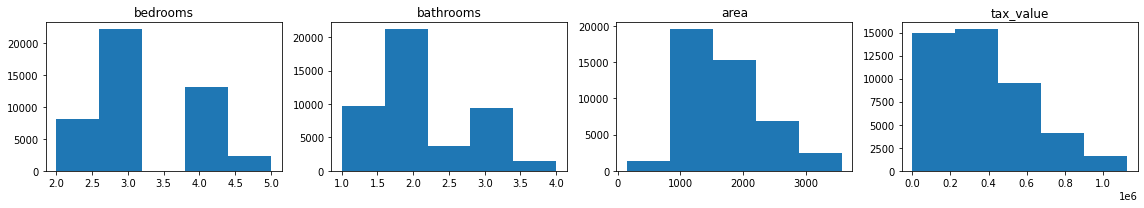

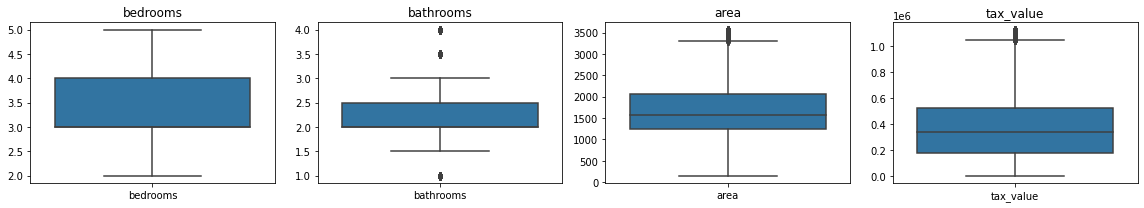

In [4]:
train, validate, test = prepare_zillow_mvp(df)

In [5]:
# All nulls have been cleared from the data and it's been split into Train, Validate, And Test.
# Time to check the full function.

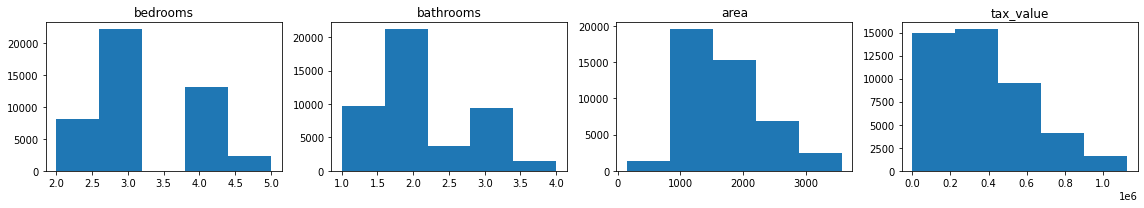

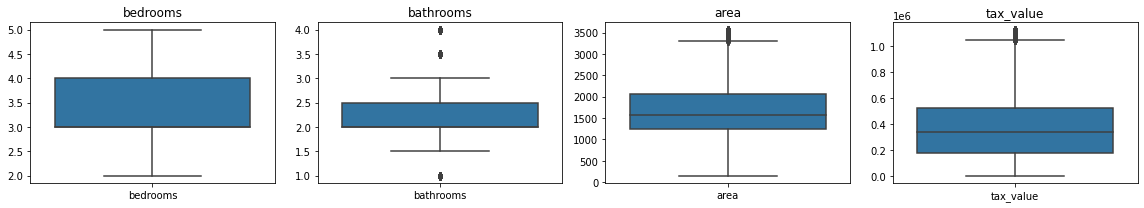

In [6]:
train, validate, test = wrangle_zillow_mvp()

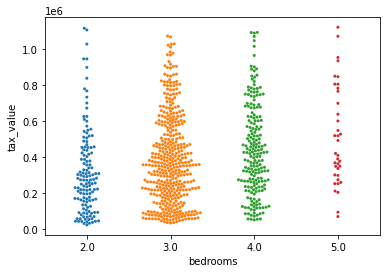

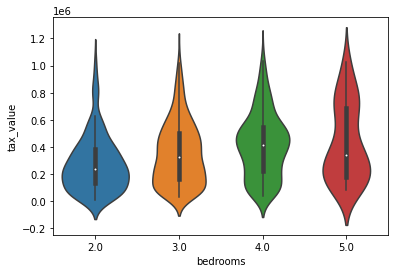

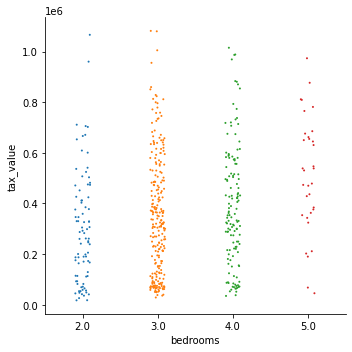

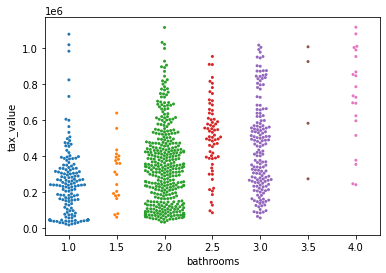

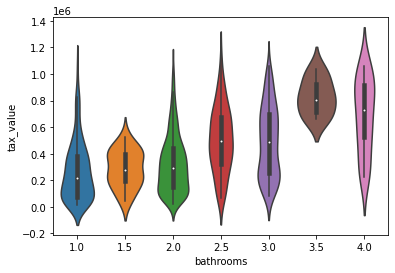

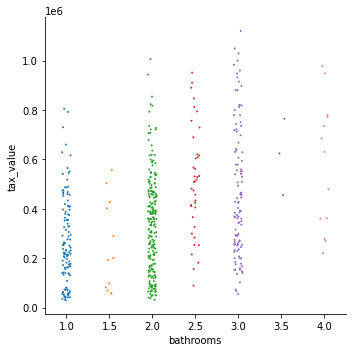

In [58]:
explore.plot_categorical_and_continuous_vars(train)

-=== bedrooms ===-
 
Value Counts:
-------------
3.0    12383
4.0     7262
2.0     4555
5.0     1350
Name: bedrooms, dtype: int64
 
Percent of Total:
-----------------
3.0    48.465753
4.0    28.422701
2.0    17.827789
5.0     5.283757
Name: bedrooms, dtype: float64
 
 >> P is less than Alpha.
 


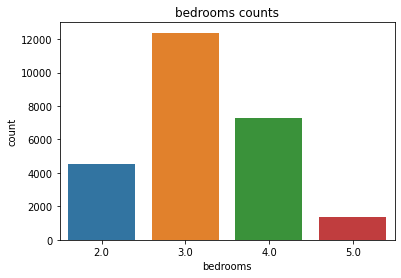

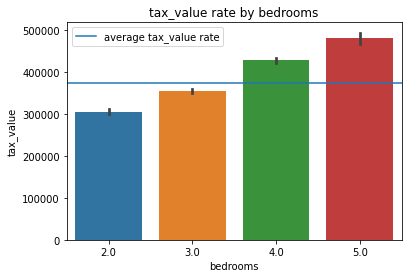

 
 
-=== bathrooms ===-
 
Value Counts:
-------------
2.0    11897
3.0     5302
1.0     4942
2.5     2068
4.0      595
1.5      487
3.5      259
Name: bathrooms, dtype: int64
 
Percent of Total:
-----------------
2.0    46.563601
3.0    20.751468
1.0    19.342466
2.5     8.093933
4.0     2.328767
1.5     1.906067
3.5     1.013699
Name: bathrooms, dtype: float64
 
 >> P is less than Alpha.
 


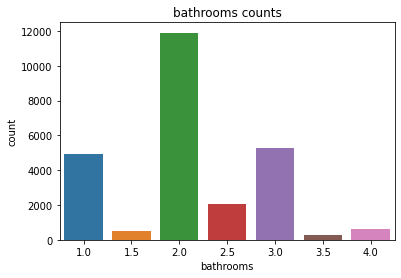

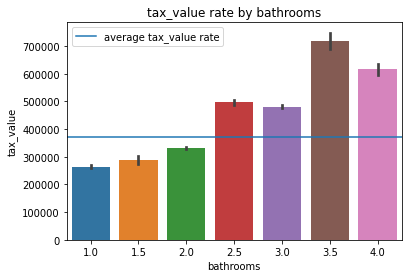

 
 
-=== tax_value ===-
 
Tax Value Average:
$ 372885.47
-------------


In [8]:
explore.explore_cat(train)

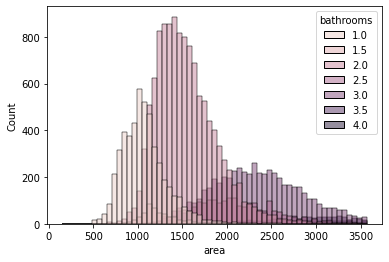

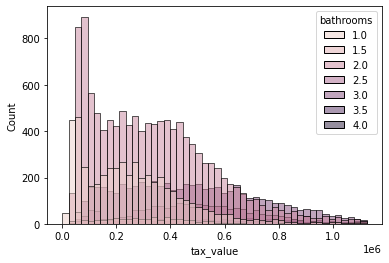

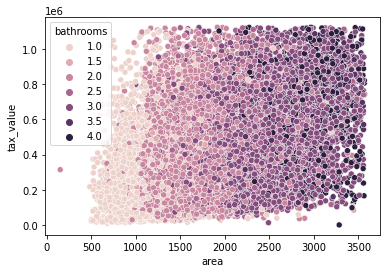

In [9]:
explore.explore_num(train)

#### Stats Testing:

##### H0:
    There is no Correlation between [Bedrooms, Bathrooms, Area] and Tax Value.
##### Ha:
    There is a Correlation between [Bedrooms, Bathrooms, Area] and Tax Value.

-------

There seems to be the lowest correlation between # of Bedrooms and Tax Value, where as there's slightly higher for Bathrooms and Tax Value, and the most (only .44 out of 1 though) between Area and Tax Value.
I'm curious since there's a larger correlation between Bathrooms and Area if I did the Area, divided by bathrooms, then checked Correlation what it would be.

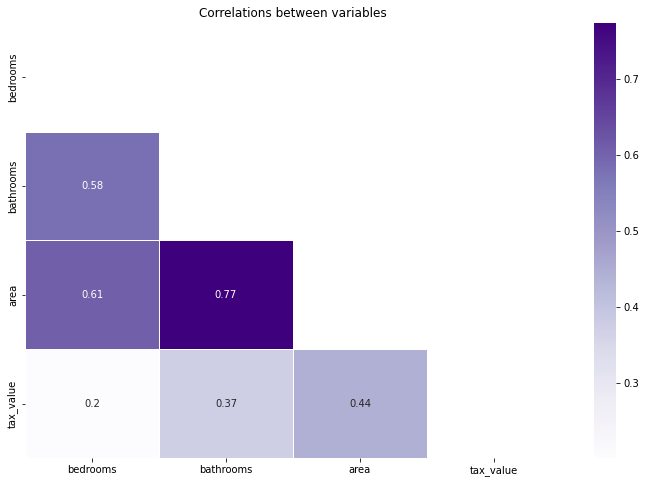

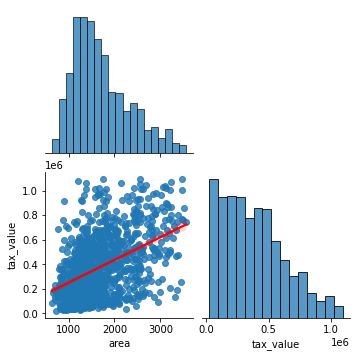

In [10]:
explore.plot_variable_pairs(train)

------

#### H0:
    There is no correlation between area by bathroom

In [11]:
# Bathrooms and Area Figure
train['area_by_bathroom'] = train['area']/train['bathrooms']
validate['area_by_bathroom'] = validate['area']/validate['bathrooms']
test['area_by_bathroom'] = test['area']/test['bathrooms']

In [12]:
train.head()

,bedrooms,bathrooms,area,tax_value,area_by_bathroom
16298,3.0,2.0,1631.0,94598.0,815.5
48457,4.0,2.0,1215.0,381640.0,607.5
52376,3.0,2.0,1671.0,208141.0,835.5
6335,2.0,2.0,1788.0,411393.0,894.0
8395,3.0,2.0,2605.0,561561.0,1302.5


In [13]:
corr, p = stats.spearmanr(train.area_by_bathroom, train.tax_value)
round(corr, 2), p

(0.07, 1.2694905890428193e-27)

woo, definitely not.

In [14]:
train['area_by_beds'] = train['area']/train['bedrooms']
validate['area_by_beds'] = validate['area']/validate['bedrooms']
test['area_by_beds'] = test['area']/test['bedrooms']

In [15]:
train.head()

,bedrooms,bathrooms,area,tax_value,area_by_bathroom,area_by_beds
16298,3.0,2.0,1631.0,94598.0,815.5,543.666667
48457,4.0,2.0,1215.0,381640.0,607.5,303.750000
52376,3.0,2.0,1671.0,208141.0,835.5,557.000000
6335,2.0,2.0,1788.0,411393.0,894.0,894.000000
8395,3.0,2.0,2605.0,561561.0,1302.5,868.333333


In [16]:
corr, p = stats.spearmanr(train.area_by_beds, train.tax_value)
round(corr, 2), p

(0.34, 0.0)

Better than Bedrooms alone at least.

What about Bedrooms and Bathrooms together?

In [17]:
train["bed_and_bath"] = train['bedrooms'] + train['bathrooms']
validate["bed_and_bath"] = validate['bedrooms'] + validate['bathrooms']
test["bed_and_bath"] = test['bedrooms'] + test['bathrooms']

train.head()

,bedrooms,bathrooms,area,tax_value,area_by_bathroom,area_by_beds,bed_and_bath
16298,3.0,2.0,1631.0,94598.0,815.5,543.666667,5.0
48457,4.0,2.0,1215.0,381640.0,607.5,303.750000,6.0
52376,3.0,2.0,1671.0,208141.0,835.5,557.000000,5.0
6335,2.0,2.0,1788.0,411393.0,894.0,894.000000,4.0
8395,3.0,2.0,2605.0,561561.0,1302.5,868.333333,5.0


In [18]:
corr, p = stats.spearmanr(train.bed_and_bath, train.tax_value)
round(corr, 2), p

(0.32, 0.0)

-------

total area by number of rooms?

In [19]:
train["rooms_and_area"] = train['bed_and_bath']/train.area
validate["rooms_and_area"] = validate['bed_and_bath']/validate.area
test["rooms_and_area"] = test['bed_and_bath']/test.area

In [20]:
train.head()

,bedrooms,bathrooms,area,tax_value,area_by_bathroom,area_by_beds,bed_and_bath,rooms_and_area
16298,3.0,2.0,1631.0,94598.0,815.5,543.666667,5.0,0.003066
48457,4.0,2.0,1215.0,381640.0,607.5,303.750000,6.0,0.004938
52376,3.0,2.0,1671.0,208141.0,835.5,557.000000,5.0,0.002992
6335,2.0,2.0,1788.0,411393.0,894.0,894.000000,4.0,0.002237
8395,3.0,2.0,2605.0,561561.0,1302.5,868.333333,5.0,0.001919


In [21]:
corr, p = stats.spearmanr(train.rooms_and_area, train.tax_value)
round(corr, 2), p

(-0.29, 0.0)

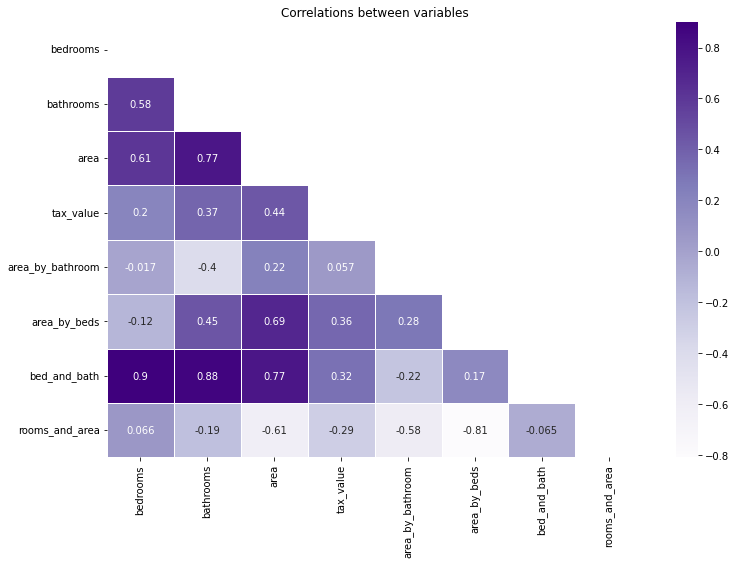

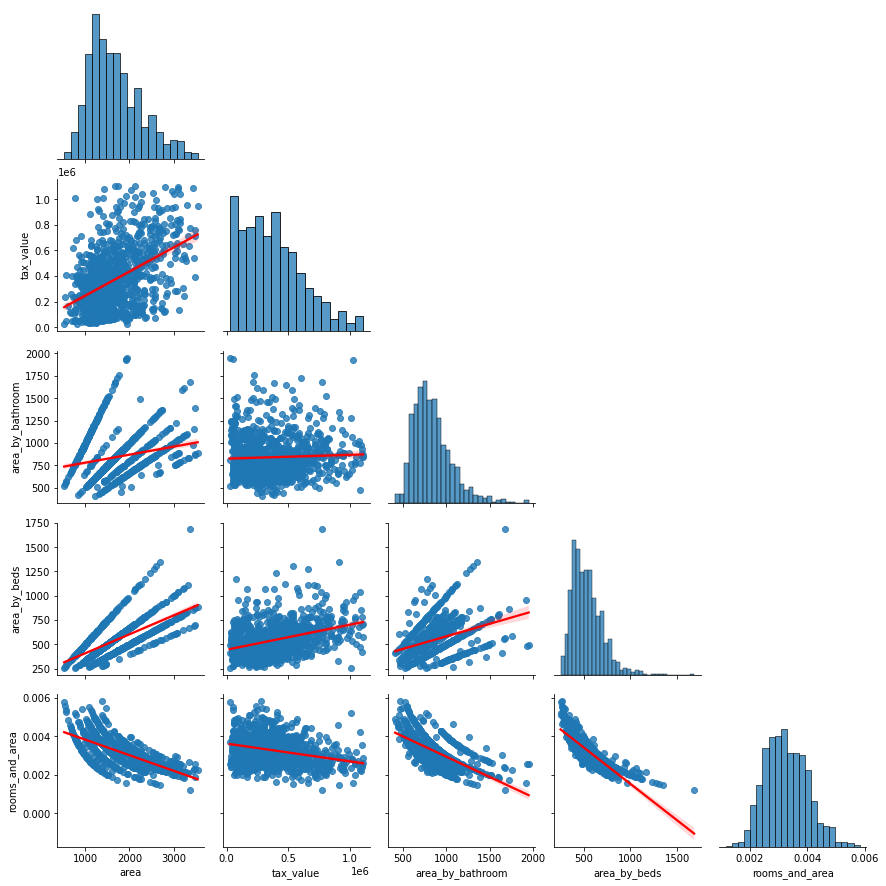

In [22]:
explore.plot_variable_pairs(train,num= ['area', 'tax_value', 'area_by_bathroom', 'area_by_beds', 'rooms_and_area'])

Tax Value and Area still have the best correlation.

-----

In [23]:
# # Scale and Check
# def scale(df, columns_for_scaling = ['bedrooms', 'bathrooms', 'tax_value'], scaler = MinMaxScaler()):
#     scaled_df = df.copy()
#     scaled_df[columns_for_scaling] = scaler.fit_transform(df[columns_for_scaling])
#     return scaled_df

In [24]:
scaled_train = scale(train, columns_for_scaling=['bedrooms', 'bathrooms', 'area_by_bathroom', 'area_by_beds', 'bed_and_bath'])
scaled_train.head()

,bedrooms,bathrooms,area,tax_value,area_by_bathroom,area_by_beds,bed_and_bath,rooms_and_area
16298,0.333333,0.333333,1631.0,94598.0,0.219958,0.310581,0.333333,0.003066
48457,0.666667,0.333333,1215.0,381640.0,0.158090,0.165406,0.500000,0.004938
52376,0.333333,0.333333,1671.0,208141.0,0.225907,0.318649,0.333333,0.002992
6335,0.000000,0.333333,1788.0,411393.0,0.243308,0.522570,0.166667,0.002237
8395,0.333333,0.333333,2605.0,561561.0,0.364813,0.507039,0.333333,0.001919


In [25]:
scaled_validate = scale(validate, columns_for_scaling=['bedrooms', 'bathrooms', 'area_by_bathroom', 'area_by_beds', 'bed_and_bath'])
scaled_test = scale(test, columns_for_scaling=['bedrooms', 'bathrooms', 'area_by_bathroom', 'area_by_beds', 'bed_and_bath'])


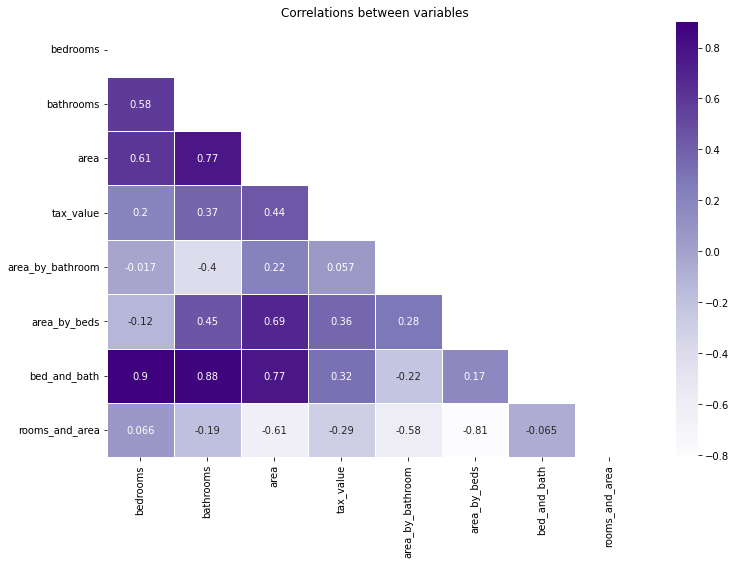

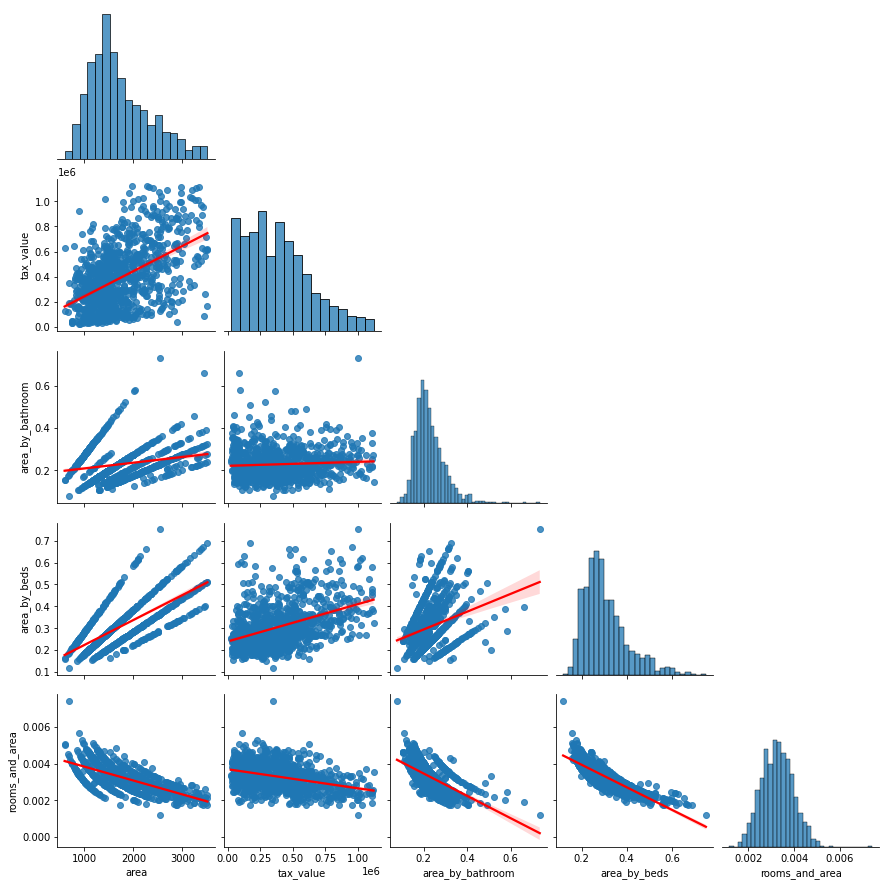

In [26]:
explore.plot_variable_pairs(scaled_train, num= ['area', 'tax_value', 'area_by_bathroom', 'area_by_beds', 'rooms_and_area'])

-------

Going to see if my assessment is correct.

In [27]:
X_train = train.drop(columns="tax_value")
y_train = train.tax_value
explore.select_best(X_train, y_train, 2)

KBest:
['bathrooms', 'area']
None
 
RFE:
['bedrooms', 'bed_and_bath']
None
 
SFS:
['bedrooms', 'area']
None


In [28]:
X_train_scaled = scaled_train.drop(columns="tax_value")
y_train_scaled = scaled_train.tax_value
explore.select_best(X_train_scaled, y_train_scaled, 2)

KBest:
['bathrooms', 'area']
None
 
RFE:
['bedrooms', 'bed_and_bath']
None
 
SFS:
['bedrooms', 'area']
None


I'm interested to see what models doing something like bedrooms and bedbath would do.

In [29]:
# # Making a X y df split def
# def df_split(train, validate, test, target="tax_value"):
#     X_train, y_train = train.drop(columns=target), train[target]
#     X_validate, y_validate = validate.drop(columns=target), validate[target]
#     X_test, y_test = test.drop(columns=target), test[target]
#     return X_train, y_train, X_validate, y_validate, X_test, y_test

In [30]:
X_train, y_train, X_validate, y_validate, X_test, y_test = df_split(train, validate, test)
y_train.mean()

tax_value    372885.466732
dtype: float64

In [31]:
X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test = df_split(scaled_train, scaled_validate, scaled_test)

In [32]:
y_train.head()

,tax_value
16298,94598.0
48457,381640.0
52376,208141.0
6335,411393.0
8395,561561.0


In [33]:
# y_train = pd.DataFrame(y_train)
# y_validate = pd.DataFrame(y_validate)
# y_test = pd.DataFrame(y_test)

In [34]:
# y_train.head()

In [35]:
# y_train['baseline_mean'] = y_train['tax_value'].mean()
# y_train['baseline_median'] = y_train['tax_value'].median()

# # scores:
# rmse_mean = mean_squared_error(y_train.tax_value,
#                                y_train['baseline_mean'], squared=False)
# rmse_med = mean_squared_error(y_train.tax_value,
#                                y_train['baseline_median'], squared=False)

# print("RMSE Mean:")
# print(rmse_mean)
# print("----------------")
# print("RMSE Median:")
# print(rmse_med)

In [36]:
explore.get_rmse(y_train, 'tax_value')

RMSE Mean:
243788.25256933476
----------------
RMSE Median:
246328.52244123278
----------------
RMSE Mean is lower so we'll use that : 243788.25256933476


In [37]:
# # applying winner to Validate
# y_validate['baseline_mean'] = y_validate['tax_value'].mean()

In [38]:
y_train.head()

,tax_value,baseline_mean,baseline_median
16298,94598.0,372885.466732,337600.5
48457,381640.0,372885.466732,337600.5
52376,208141.0,372885.466732,337600.5
6335,411393.0,372885.466732,337600.5
8395,561561.0,372885.466732,337600.5


(array([4119., 4236., 4426., 4156., 3195., 2210., 1367.,  934.,  553.,
         354.]),
 array([1.0000000e+03, 1.1325540e+05, 2.2551080e+05, 3.3776620e+05,
        4.5002160e+05, 5.6227700e+05, 6.7453240e+05, 7.8678780e+05,
        8.9904320e+05, 1.0112986e+06, 1.1235540e+06]),
 <BarContainer object of 10 artists>)

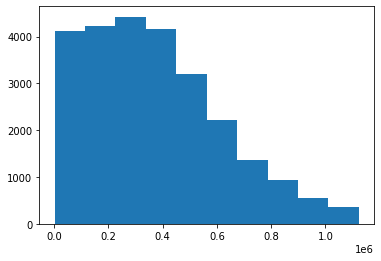

In [39]:
# # Checking Shapes
plt.hist(y_train.tax_value)

In [40]:
# # assessing out of sample model performance
# metric_df = explore.create_metric_df(y_train)
# metric_df

In [41]:
# def model_metrics(model,
#                   model_name,
#                   X_train, 
#                   y_train, 
#                   X_val, 
#                   y_val, 
#                   target = 'tax_value',
#                   scores=metric_df):
#     '''
#     model_metrics will use an sklearn model object to 
#     create predictions after fitting on our training set, and add
#     the model scores to a pre-established metric_df
#     returns: metric_df
#     '''
#     # fit our model object
#     model.fit(X_train, y_train[target])
#     in_sample_pred = model.predict(X_train)
#     out_sample_pred = model.predict(X_val)
#     y_train[model_name] = in_sample_pred
#     y_val[model_name] = out_sample_pred
#     print(y_val.shape)
#     print(out_sample_pred.shape)
#     rmse_val = mean_squared_error(
#     y_val[target], out_sample_pred, squared=False)
#     r_squared_val = explained_variance_score(
#         y_val[target], out_sample_pred)
#     return metric_df.append({
#         'model': model_name,
#         'rmse': rmse_val,
#         'r^2': r_squared_val
    
#     }, ignore_index=True)

In [42]:
# metric_df = explore.model_metrics(LinearRegression(),
#                   "linear_reg", 
#                   X_train_scaled, 
#                   y_train, 
#                   X_validate_scaled, 
#                   y_validate, 
#                   metric_df)

In [43]:
# # create the model object
# lm = LinearRegression(normalize=True)

# # fit the model to our training data. We must specify the column in y_train, 
# # since we have converted it to a dataframe from a series! 
# lm.fit(X_train, y_train.tax_value)

# # predict train
# y_train['tax_value_pred_lm'] = lm.predict(X_train)

# # evaluate: rmse
# rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm)**(1/2)

# # predict validate
# y_validate['tax_value_pred_lm'] = lm.predict(X_validate)

# # evaluate: rmse
# rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm)**(1/2)

# print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
#       "\nValidation/Out-of-Sample: ", rmse_validate)

In [44]:
# metric_df

In [45]:
# metric_df = explore.model_metrics(LassoLars(alpha=1.0),
#                   "lasso_lars_alpha1", 
#                   X_train_scaled, 
#                   y_train, 
#                   X_validate_scaled, 
#                   y_validate, 
#                   metric_df)

In [46]:
# # create the model object
# lars = LassoLars(alpha=1.0)

# # fit the model to our training data. We must specify the column in y_train, 
# # since we have converted it to a dataframe from a series! 
# lars.fit(X_train, y_train.tax_value)

# # predict train
# y_train['tax_value_pred_lars'] = lars.predict(X_train)

# # evaluate: rmse
# rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars)**(1/2)

# # predict validate
# y_validate['tax_value_pred_lars'] = lars.predict(X_validate)

# # evaluate: rmse
# rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars)**(1/2)

# print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
#       "\nValidation/Out-of-Sample: ", rmse_validate)

In [47]:
# metric_df

In [48]:
# metric_df = explore.polyfeatures(X_train_scaled, y_train, X_validate_scaled, y_validate, metric_df)
# metric_df

In [49]:
# y_train.head()

In [50]:
# # create the model object
# glm = TweedieRegressor(power=1, alpha=0)

# # fit the model to our training data. We must specify the column in y_train, 
# # since we have converted it to a dataframe from a series! 
# glm.fit(X_train, y_train.tax_value)

# # predict train
# y_train['tax_value_pred_glm'] = glm.predict(X_train)

# # evaluate: rmse
# rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm)**(1/2)

# # predict validate
# y_validate['tax_value_pred_glm'] = glm.predict(X_validate)

# # evaluate: rmse
# rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_glm)**(1/2)

# print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
#       "\nValidation/Out-of-Sample: ", rmse_validate)

In [51]:
y_train_models, y_validate_models = explore.rmse_in_out(X_train, y_train, X_validate, y_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  216809.05147501625 
Validation/Out-of-Sample:  220529.14572104753
-----
RMSE for Lasso + Lars
Training/In-Sample:  216815.01775620607 
Validation/Out-of-Sample:  220525.81959140726
-----
RMSE for GLM (Generalised Linar Model) using Tweedie, power=1 & alpha=0
Training/In-Sample:  243788.25256933476 
Validation/Out-of-Sample:  247065.52052137486


In [52]:
y_train_models.head()

,tax_value,baseline_mean,baseline_median,pred_lm,pred_lars,pred_glm
16298,94598.0,372885.466732,337600.5,363735.587776,363718.873361,372885.466732
48457,381640.0,372885.466732,337600.5,247482.636839,252227.783995,372885.466732
52376,208141.0,372885.466732,337600.5,370300.306361,370590.369786,372885.466732
6335,411393.0,372885.466732,337600.5,417404.824018,420956.075248,372885.466732
8395,561561.0,372885.466732,337600.5,535304.621551,535068.950996,372885.466732


In [53]:
explore.model_metrics_all(X_train, y_train, X_validate, y_validate)

RMSE Mean is lower so we'll use that : 243788.25256933476
y shape:
(10951, 5)
----------
out of sample shape:
(10951,)
y shape:
(10951, 6)
----------
out of sample shape:
(10951,)
y shape:
(10951, 7)
----------
out of sample shape:
(10951,)
y shape:
(10951, 8)
----------
out of sample shape:
(10951,)


,model,rmse,r^2
0,baseline_mean,5.943271e+10,0.000000
1,linear_regression,2.205291e+05,0.203286
2,lasso_lars,2.205258e+05,0.203305
3,glm,2.470655e+05,0.000000
4,polynomial_regression_deg2,2.205367e+05,0.203226


In [56]:
# compute residuals
y_train['lm_residual'] = y_train['linear_regression'] - y_train['tax_value']
y_train['lasso_lars_residual'] = y_train['lasso_lars'] - y_train['tax_value']
y_train['glm_residual'] = y_train['glm'] - y_train['tax_value']
y_train['polynomial_residual'] = y_train['polynomial_regression_deg2'] - y_train['tax_value']

y_train['residual_baseline'] = y_train['baseline_mean'] - y_train['tax_value']

In [57]:
y_train.head()

,tax_value,baseline_mean,baseline_median,pred_lm,pred_lars,pred_glm,linear_regression,lasso_lars,glm,polynomial_regression_deg2,lm_residual,residual_baseline,lasso_lars_residual,glm_residual,polynomial_residual
16298,94598.0,372885.466732,337600.5,363735.587776,363718.873361,372885.466732,363735.587776,363718.873361,372885.466732,363320.187857,269137.587776,278287.466732,269120.873361,278287.466732,268722.187857
48457,381640.0,372885.466732,337600.5,247482.636839,252227.783995,372885.466732,247482.636839,252227.783995,372885.466732,249160.810440,-134157.363161,-8754.533268,-129412.216005,-8754.533268,-132479.189560
52376,208141.0,372885.466732,337600.5,370300.306361,370590.369786,372885.466732,370300.306361,370590.369786,372885.466732,370146.086518,162159.306361,164744.466732,162449.369786,164744.466732,162005.086518
6335,411393.0,372885.466732,337600.5,417404.824018,420956.075248,372885.466732,417404.824018,420956.075248,372885.466732,414394.055877,6011.824018,-38507.533268,9563.075248,-38507.533268,3001.055877
8395,561561.0,372885.466732,337600.5,535304.621551,535068.950996,372885.466732,535304.621551,535068.950996,372885.466732,534924.859793,-26256.378449,-188675.533268,-26492.049004,-188675.533268,-26636.140207
